## В данном ноутбуке показан пример обучения модели классификации людей в очках и без

В качестве обучающей выборки используется синтетический датасет с [kaggle](https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses)

In [1]:
import multiprocessing
import os
import pickle
import sys
import typing
import uuid
import zipfile
from collections import Counter

import cv2
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.models import resnet
from tqdm.auto import tqdm

tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger(__name__)
logger.setLevel('ERROR')
import matplotlib.pyplot as plt
logger = logging.getLogger('matplotlib')
logger.setLevel('ERROR')
import PIL
from PIL import Image
logger = logging.getLogger('PIL')
logger.setLevel('ERROR')


print(sys.version_info)
print(torch.__version__)
print(torch.cuda.is_available())

sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
1.8.1+cu111
False


In [2]:
os.environ["WANDB_CONSOLE"] = "off"
# torch.set_num_threads(8)
# torch.set_num_interop_threads(8)

import wandb

In [3]:
root = "/home/jovyan/Untitled Folder"
# root = "https://storage.yandexcloud.net/jupyter.asciishell.ru"

In [4]:
df = pd.read_csv(f"{root}/train.csv")[["id", "glasses"]].copy()

In [5]:
df_train, df_valid = train_test_split(df, test_size=0.3, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.33, random_state=42)

Используются следующие аугментации для изображений:
- Случайный кроп
- Зеркальное отражение
- Смещение цветов
- Перевод в серый цвет

In [6]:
df_train.shape, df_valid.shape

((3150, 2), (904, 2))

In [7]:
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
    ]
)


class FaseDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root: str,
        size,
        sample: pd.DataFrame,
        transform: typing.Callable,
    ):
        self.root = root
        self.size = size
        self.ids = sample["id"].values
        self.targets = sample["glasses"].values
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img, target = self.ids[index], self.targets[index]
        img = Image.open(self.root.format(img))
        img = img.resize(self.size, Image.Resampling.BILINEAR)

        pos_1 = self.transform(img)
        pos_2 = self.transform(img)

        return pos_1, pos_2, target

In [8]:
im_size = (224, 224)
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    FaseDataset(f"{root}/faces-spring-2020/faces-spring-2020/face-{{}}.png", im_size, df_train, train_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    FaseDataset(f"{root}/faces-spring-2020/faces-spring-2020/face-{{}}.png", im_size, df_valid, test_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)

В качестве базовой модели используется resnet18 с 2 головами - одна для обучения эмбеддингов, вторая для классификации.
Опционально можно выбрать другую базовую модель (resnet34 или 50).

Дополнительно используется NT-Xent loss в SimCLR подходе.
https://arxiv.org/pdf/2002.05709.pdf

In [9]:
class Model(torch.nn.Module):
    def __init__(self, feature_dim=128, arch="resnet18", init=True):
        super(Model, self).__init__()

        self.f = []

        if arch == "resnet18":
            w = resnet.ResNet18_Weights.DEFAULT if init else None
            module = resnet.resnet18(weights=w)
            in_size = 512
        elif arch == "resnet34":
            w = resnet.ResNet34_Weights.DEFAULT if init else None
            module = resnet.resnet34(weights=w)
            in_size = 512
        elif arch == "resnet50":
            w = resnet.ResNet50_Weights.DEFAULT if init else None
            module = resnet.resnet50(weights=w)
            in_size = 2048
        else:
            raise Exception("Unknown module {}".format(repr(arch)))
        for name, module in module.named_children():
            # if name == "conv1":
            #     module = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            # if not isinstance(module, torch.nn.Linear) and not isinstance(module, torch.nn.MaxPool2d):
            if not isinstance(module, torch.nn.Linear):
                self.f.append(module)
        # encoder
        self.f = torch.nn.Sequential(*self.f)
        self.c = torch.nn.Linear(in_size, 2, bias=True)
        # projection head
        self.g = torch.nn.Sequential(
            torch.nn.Linear(in_size, 512, bias=False),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, feature_dim, bias=True),
        )

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        proba = self.c(feature)
        return F.normalize(out, dim=-1), proba


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, temperature, cuda):
        super().__init__()
        self.temperature = temperature
        self.cuda = cuda

    def get_negative_mask(self, batch_size):
        negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
        for i in range(batch_size):
            negative_mask[i, i] = 0
            negative_mask[i, i + batch_size] = 0

        negative_mask = torch.cat((negative_mask, negative_mask), 0)
        return negative_mask

    def forward(self, out_1, out_2):
        batch_size = out_1.shape[0]

        # neg score
        out = torch.cat([out_1, out_2], dim=0)
        neg = torch.exp(torch.mm(out, out.t().contiguous()) / self.temperature)
        mask = self.get_negative_mask(batch_size)
        if self.cuda:
            mask = mask.cuda()
        neg = neg.masked_select(mask).view(2 * batch_size, -1)

        # pos score
        pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / self.temperature)
        pos = torch.cat([pos, pos], dim=0)

        # estimator g()
        Ng = neg.sum(dim=-1)

        # contrastive loss
        loss = (-torch.log(pos / (pos + Ng))).mean()

        return loss

In [10]:
def main(
    *,
    model,
    criterion_cls,
    criterion_contrastive,
    optimizer,
    writer,
    train_loader,
    valid_loader,
    checkpoint_path,
    cuda=True,
    epochs=200,
    alpha=0.1,
):
    if cuda:
        model = model.cuda()
    model = torch.nn.DataParallel(model)
    step = 0
    for epoch in range(1, epochs + 1):
        epoch_alpha = alpha + (1.0 - alpha) * (epoch / epochs)
        writer.add_scalar("train/alpha", epoch_alpha, epoch)
        model.train()
        total_loss, total_num = 0.0, 0
        for pos_1, pos_2, target in tqdm(train_loader, desc=f"Train {epoch}"):
            if cuda:
                pos_1 = pos_1.cuda(non_blocking=True)
                pos_2 = pos_2.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)
            out_1, out_1_proba = model(pos_1)
            out_2, out_2_proba = model(pos_2)

            loss = epoch_alpha * (criterion_cls(out_1_proba, target) + criterion_cls(out_2_proba, target)) + (
                1.0 - epoch_alpha
            ) * criterion_contrastive(out_1, out_2)
            writer.add_scalar("loss/train", loss, step)
            step += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_num += batch_size
            total_loss += loss.item() * batch_size

        train_loss = total_loss / total_num

        if epoch % 1 == 0:
            with torch.no_grad():
                model.eval()
                predicts = []
                targets = []
                for pos_1, pos_2, target in tqdm(valid_loader, desc=f"Valid {epoch}"):
                    if cuda:
                        pos_1 = pos_1.cuda(non_blocking=True)
                    _, predict = model(pos_1)
                    predicts.extend(predict.cpu().numpy())
                    targets.extend(target.cpu().numpy())
            predicts = np.stack(predicts)
            targets = np.stack(targets)
            writer.add_scalar("valid/f1w", f1_score(targets, predicts.argmax(axis=1), average="weighted"), epoch)
            writer.add_scalar("valid/acc", accuracy_score(targets, predicts.argmax(axis=1)), epoch)
            writer.add_scalar(
                "valid/roc_auc",
                roc_auc_score(targets, scipy.special.softmax(predicts, axis=1)[:, 1]),
                epoch,
            )
            torch.save(model.state_dict(), checkpoint_path.format(epoch))
        writer.flush()
    writer.close()

In [11]:
def main2():
    cuda = False
    epochs = 10
    model_arch = "resnet18"
    init = True
    cls_w = 0.5
    run = f"glass-{model_arch}-init={init}-cls_w={cls_w}-bs={batch_size}"
    os.makedirs(run, exist_ok=True)
    wandb.init(
        project="glasses_cv",
        dir=run,
        name=run,
        config={
            "model": model_arch,
            "init": init,
            "classification_weight": cls_w,
            "batch_size": batch_size,
            "epochs": epochs,
        },
    )
    wandb.tensorboard.patch(root_logdir=run)
    writer = SummaryWriter(run)

    model = Model(64, model_arch, init)
    criterion_cls = torch.nn.CrossEntropyLoss()
    criterion_contrastive = ContrastiveLoss(0.5, cuda)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    print("Start", run)
    main(
        model=model,
        criterion_cls=criterion_cls,
        criterion_contrastive=criterion_contrastive,
        optimizer=optimizer,
        writer=writer,
        train_loader=train_loader,
        valid_loader=test_loader,
        checkpoint_path=f"{run}/model_{{}}.pt",
        cuda=cuda,
        epochs=epochs,
        alpha=cls_w,
    )

    writer.close()
    wandb.finish()
    wandb.tensorboard.unpatch()


if __name__ == "__main__":
    main2()

wandb: Currently logged in as: piksaevalex. Use `wandb login --relogin` to force relogin


2022-12-14 14:48:18.002023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 14:48:18.303384: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-14 14:48:20.932433: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nv

Start glass-resnet18-init=True-cls_w=0.5-bs=256


2022-12-14 14:48:24.296851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 14:48:24.414057: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Train 1:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-14 14:48:25.389470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-14 14:48:25.389557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-14 14:48:25.389564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries men

Valid 1:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dat

Train 2:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
Traceback (most recent call last):

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
            self._shutdown_workers()se

Valid 2:   0%|          | 0/4 [00:01<?, ?it/s]

Train 3:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 3:   0%|          | 0/4 [00:00<?, ?it/s]

Train 4:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 4:   0%|          | 0/4 [00:00<?, ?it/s]

Train 5:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dat

Valid 5:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: Exception ignored in:   File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
            self

Train 6:   0%|          | 0/13 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>    Exception ignored in: self._shutdown_workers()
self._shutdown_workers()
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

  File "/home/jovyan/.imgen

Valid 6:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
                

Train 7:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 7:   0%|          | 0/4 [00:00<?, ?it/s]

Train 8:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 8:   0%|          | 0/4 [00:00<?, ?it/s]

Train 9:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dat

Valid 9:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
            self

Train 10:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>Traceback (most recent call last):

Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:   File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2f3c846950>        Traceback

global_step,▁▁▁▁▂▂▂▁▂▃▃▁▃▃▄▁▄▄▄▁▅▅▅▁▅▆▆▁▆▆▇▁▇▇▇▁███▂
loss/train,█▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▃▂▂▂▂▁▁▁▁
train/alpha,▁▂▃▃▄▅▆▆▇█
valid/acc,▅▄██▂▇▆▇▃▁
valid/f1w,▅▅██▃▇▆▇▃▁
valid/roc_auc,▁▅█▆▂▆▁▆▄▁
global_step,10
loss/train,0.54796
train/alpha,1.0
valid/acc,0.87721
valid/f1w,0.87533


Получаем предсказания модели

In [12]:
model = Model(64, arch="resnet18")
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('./glass-resnet18-init=True-cls_w=0.5-bs=256/model_4.pt'))
model.eval();

In [13]:
def predict_with_model(model, images):
    if isinstance(images, Image.Image):
        images = [images]
    images = [img.resize((224, 224), Image.Resampling.BILINEAR) for img in images]
    test_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        ]
    )
    images = torch.stack([test_transforms(img) for img in images], dim=0)
    with torch.no_grad():
        emb, proba = model(images)
    proba = scipy.special.softmax(proba, axis=1)
    return emb.cpu().numpy(), proba.cpu().numpy()

0.1008129


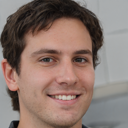

In [14]:
img = Image.open(f"{root}/faces-spring-2020/faces-spring-2020/face-1.png")
_, proba = predict_with_model(model, img)
print(proba[0][1])
img.resize((128, 128))

In [15]:
from glob import glob
testss = glob('*.jpg')
len(testss)

7

0.8703806


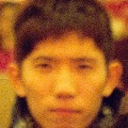

In [16]:
img = Image.open(f"{root}/{testss[2]}")
_, proba = predict_with_model(model, img)
print(proba[0][1])
img.resize((128, 128))

In [19]:
model = Model(64, arch="resnet18")
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('model_9.pt'))
model.eval();

0.00019684115


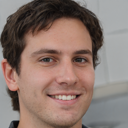

In [18]:
img = Image.open(f"{root}/faces-spring-2020/faces-spring-2020/face-1.png")
_, proba = predict_with_model(model, img)
print(proba[0][1])
img.resize((128, 128))

In [11]:
oos_loader = torch.utils.data.DataLoader(
    FaseDataset(f"{root}/faces-spring-2020/faces-spring-2020/face-{{}}.png", im_size, df_test, test_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)

In [11]:
from torch import nn
from torchvision import models

class MobileNetV3(nn.Module):
    def __init__(self, num_classes, use_pre_trained=True):
        super().__init__()

        model = models.mobilenet_v3_large(use_pre_trained)
        self.num_classes = num_classes
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = nn.Sequential(
            model.classifier[:3],
            nn.Linear(model.classifier[3].in_features, num_classes, bias=True)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)

        x = self.avgpool(x)
        out = torch.flatten(x, 1)

        x = self.classifier(out)
        if self.num_classes == 1:
            x = self.sigmoid(x)

        return F.normalize(out, dim=-1), x

In [13]:
def main3():
    cuda = False
    epochs = 10
    model_arch = "mobilnet"
    init = True
    cls_w = 0.5
    run = f"glass-{model_arch}-init={init}-cls_w={cls_w}-bs={batch_size}"
    os.makedirs(run, exist_ok=True)
    wandb.init(
        project="glasses_cv",
        dir=run,
        name=run,
        config={
            "model": model_arch,
            "init": init,
            "classification_weight": cls_w,
            "batch_size": batch_size,
            "epochs": epochs,
        },
    )
    wandb.tensorboard.patch(root_logdir=run)
    writer = SummaryWriter(run)
    try:
        model = MobileNetV3(2, init)
        criterion_cls = torch.nn.CrossEntropyLoss()
        criterion_contrastive = ContrastiveLoss(0.5, cuda)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

        print("Start", run)
        main(
            model=model,
            criterion_cls=criterion_cls,
            criterion_contrastive=criterion_contrastive,
            optimizer=optimizer,
            writer=writer,
            train_loader=train_loader,
            valid_loader=test_loader,
            checkpoint_path=f"{run}/model_{{}}.pt",
            cuda=cuda,
            epochs=epochs,
            alpha=cls_w,
        )
    finally:
        writer.close()
        wandb.finish()
        wandb.tensorboard.unpatch()


if __name__ == "__main__":
    main3()

wandb: Currently logged in as: piksaevalex. Use `wandb login --relogin` to force relogin


2022-12-15 10:12:39.365329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 10:12:39.489899: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-15 10:12:41.379380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nv

Start glass-mobilnet-init=True-cls_w=0.5-bs=256


2022-12-15 10:12:44.317364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 10:12:44.443380: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Train 1:   0%|          | 0/13 [00:00<?, ?it/s]

2022-12-15 10:12:45.359127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-15 10:12:45.359204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-15 10:12:45.359211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries men

Valid 1:   0%|          | 0/4 [00:00<?, ?it/s]

Train 2:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dat

Valid 2:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):


  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
                

Train 3:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 3:   0%|          | 0/4 [00:00<?, ?it/s]

Train 4:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dat

Valid 4:   0%|          | 0/4 [00:00<?, ?it/s]

Train 5:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>Exception ignored in: 

Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
          File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._sh

Valid 5:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>Exception ignored in:   File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>Traceback (most recent call last):

  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>    self._shutdown_workers()    self._shutdown_workers()

self._shutdown_workers()
Traceback (most recent call last):

  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.

Train 6:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 6:   0%|          | 0/4 [00:00<?, ?it/s]

Train 7:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dat

Valid 7:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dat

Train 8:   0%|          | 0/13 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>Traceback (most recent call last):

  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    
Traceback (most recent call last):
self._shutdown_workers()Traceback (most recent call last):
      File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()  File "/home/jovyan/.img

Valid 8:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>


<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
            self

Train 9:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 9:   0%|          | 0/4 [00:00<?, ?it/s]

Train 10:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2d45769320>
Traceback (most recent call last):
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jovyan/.imgenv-envcpu-0/lib/python3.7/site-packages/torch/utils/data/dat

Valid 10:   0%|          | 0/4 [00:00<?, ?it/s]

global_step,▁▁▁▁▂▂▂▁▂▃▃▁▃▃▄▁▄▄▄▁▅▅▅▁▅▆▆▁▆▆▇▁▇▇▇▁███▂
loss/train,██▇█▇▆▆▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▂▂▃▃▂▂▂▂▁▁▁▁
train/alpha,▁▂▃▃▄▅▆▆▇█
valid/acc,▃▁▁▅▆▃▇██▅
valid/f1w,▃▁▁▆▆▃▇██▅
valid/roc_auc,▂▁▅▄▆▃▄██▇
global_step,10
loss/train,0.40691
train/alpha,1.0
valid/acc,0.86726
valid/f1w,0.8621


In [14]:
model = MobileNetV3(2, False)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('glass-mobilnet-init=True-cls_w=0.5-bs=256/model_9.pt'))
model.eval();

In [18]:
cuda = False
with torch.no_grad():
    model.eval()
    predicts = []
    targets = []
    for pos_1, pos_2, target in tqdm(oos_loader, desc=f"Test"):
        if cuda:
            pos_1 = pos_1.cuda(non_blocking=True)
        _, predict = model(pos_1)
        predicts.extend(predict.cpu().numpy())
        targets.extend(target.cpu().numpy())
predicts = np.stack(predicts)
targets = np.stack(targets)
print("f1", f1_score(targets, predicts.argmax(axis=1), average=None))
print("f1 macro", f1_score(targets, predicts.argmax(axis=1), average='macro'))
print("f1 weighted", f1_score(targets, predicts.argmax(axis=1), average='weighted'))

print("acc", accuracy_score(targets, predicts.argmax(axis=1)))
print("roc_auc", roc_auc_score(targets, scipy.special.softmax(predicts, axis=1)[:, 1]))

Test:   0%|          | 0/2 [00:00<?, ?it/s]

f1 [0.85106383 0.91296625]
f1 macro 0.8820150410037413
f1 weighted 0.8904815158208128
acc 0.8901345291479821
roc_auc 0.9455529473135107


In [12]:
from torch import nn
from torchvision import models

class WideResnet50(nn.Module):
    def __init__(self, num_classes, use_pre_trained=True):
        super().__init__()

        model = models.wide_resnet50_2(use_pre_trained)
        self.num_classes = num_classes
        self.features = nn.Sequential(*list(model.children())[:-1])
        in_features = model.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(in_features, num_classes, bias=True)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)

        out = torch.flatten(x, 1)

        x = self.classifier(out)
        if self.num_classes == 1:
            x = self.sigmoid(x)

        return F.normalize(out, dim=-1), x

In [13]:
def main3():
    cuda = False
    epochs = 10
    model_arch = "wideresnet"
    init = True
    cls_w = 0.5
    run = f"glass-{model_arch}-init={init}-cls_w={cls_w}-bs={batch_size}"
    os.makedirs(run, exist_ok=True)
    # wandb.init(
    #     project="glasses_cv",
    #     dir=run,
    #     name=run,
    #     config={
    #         "model": model_arch,
    #         "init": init,
    #         "classification_weight": cls_w,
    #         "batch_size": batch_size,
    #         "epochs": epochs,
    #     },
    # )
    # wandb.tensorboard.patch(root_logdir=run)
    writer = SummaryWriter(run)
    try:
        model = WideResnet50(2, init)
        criterion_cls = torch.nn.CrossEntropyLoss()
        criterion_contrastive = ContrastiveLoss(0.5, cuda)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

        print("Start", run)
        main(
            model=model,
            criterion_cls=criterion_cls,
            criterion_contrastive=criterion_contrastive,
            optimizer=optimizer,
            writer=writer,
            train_loader=train_loader,
            valid_loader=test_loader,
            checkpoint_path=f"{run}/model_{{}}.pt",
            cuda=cuda,
            epochs=epochs,
            alpha=cls_w,
        )
    finally:
        writer.close()
        # wandb.finish()
        # wandb.tensorboard.unpatch()


if __name__ == "__main__":
    main3()

Start glass-wideresnet-init=True-cls_w=0.5-bs=256


Train 1:   0%|          | 0/13 [00:00<?, ?it/s]

Valid 1:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3465e11440>
Traceback (most recent call last):
  File "/home/user/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/user/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/user/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3465e11440>
Traceback (most recent call last):
  File "/home/user/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/user/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if 

Train 2:   0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
model = WideResnet50(2, False)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('glass-wideresnet-init=True-cls_w=0.5-bs=256/model_1.pt'))
model.eval();

In [15]:
cuda = False
with torch.no_grad():
    model.eval()
    predicts = []
    targets = []
    for pos_1, pos_2, target in tqdm(oos_loader, desc=f"Test"):
        if cuda:
            pos_1 = pos_1.cuda(non_blocking=True)
        _, predict = model(pos_1)
        predicts.extend(predict.cpu().numpy())
        targets.extend(target.cpu().numpy())
predicts = np.stack(predicts)
targets = np.stack(targets)
print("f1", f1_score(targets, predicts.argmax(axis=1), average=None))
print("f1 macro", f1_score(targets, predicts.argmax(axis=1), average='macro'))
print("f1 weighted", f1_score(targets, predicts.argmax(axis=1), average='weighted'))

print("acc", accuracy_score(targets, predicts.argmax(axis=1)))
print("roc_auc", roc_auc_score(targets, scipy.special.softmax(predicts, axis=1)[:, 1]))

Test:   0%|          | 0/2 [00:00<?, ?it/s]

f1 [0.84210526 0.90181818]
f1 macro 0.8719617224880383
f1 weighted 0.8801287360267771
acc 0.8789237668161435
roc_auc 0.9344787862980352
